In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

plt.style.use('ggplot')
mpl.rcParams['scatter.edgecolors'] = 'black'
mpl.rcParams['lines.markeredgecolor'] = 'black'


data_dir = Path('../data/hdf')
data_file = data_dir / '30449.h5'


Pull out all of the signal names, shapes, dimensions, and data types from the sample HDF5 file.

In [2]:
def load_hdf(path):
    results = []

    def _visitor(name, node):
        if isinstance(node, h5py.Dataset):
            shape = node.shape
            shape = tuple(v for v in shape if v != 1)
            n_dims = len(shape) if len(node.shape) >= 1 else 1 
            units = node.attrs.get('units', '')
            label = node.parent.attrs.get('label', '')
            description = node.parent.attrs.get('description', '')
            result = dict(name=name, shape=shape, n_dims=n_dims, dtype=node.dtype, units=units, label=label, description=description)
            results.append(result)
            
    with h5py.File(path) as handle:
        handle.visititems(_visitor)
        meta_df = pd.DataFrame(results)
    meta_df['shot_id'] = int(data_file.stem)
    return meta_df

meta_df = load_hdf(data_file)
meta_df.head(1000)

,name,shape,n_dims,dtype,units,label,description,shot_id
0,abm/CALIB_SHOT/data,(),0,int16,,Calibration Shot,,30449
1,abm/CALIB_SHOT/errors,(),0,int16,,Calibration Shot,,30449
2,abm/CALIB_SHOT/time,(),0,float32,S,Calibration Shot,,30449
3,abm/CHANNEL_STATUS/data,"(32,)",1,float32,,channel_status,,30449
4,abm/CHANNEL_STATUS/errors,"(32,)",1,float32,,channel_status,,30449
...,...,...,...,...,...,...,...,...
995,amc/STATUS/time,(),0,float32,S,,,30449
996,amc/TF CURRENT/data,"(30000,)",1,float32,kA,TF Current,,30449
997,amc/TF CURRENT/errors,"(30000,)",1,float32,,TF Current,,30449
998,amc/TF CURRENT/time,"(30000,)",1,float32,s,TF Current,,30449


There are approximately ~2 billion data points for a given shot

In [3]:
sep = '/'
meta_df['n_elements'] = meta_df['shape'].apply(np.prod)
meta_df['signal_name'] = meta_df.name.map(lambda x: sep.join(x.split(sep)[:-1]))
meta_df['source_name'] = meta_df.name.map(lambda x: x.split(sep)[0])
meta_df['signal_type'] = meta_df.name.map(lambda x: x.split(sep)[-1])
meta_df.n_elements.sum()

1944466520.0

There are approximately 17795 different signals for a given shot

In [4]:
print('Signals', len(meta_df.signal_name.unique()))
print('Sources', len(meta_df.source_name.unique()))

Signals 17795
Sources 64


In [5]:
data_signals = meta_df.loc[meta_df.signal_type == 'data']
data_signals

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
0,abm/CALIB_SHOT/data,(),0,int16,,Calibration Shot,,30449,1.0,abm/CALIB_SHOT,abm,data
3,abm/CHANNEL_STATUS/data,"(32,)",1,float32,,channel_status,,30449,32.0,abm/CHANNEL_STATUS,abm,data
6,abm/CHANNEL_TYPE/data,"(32,)",1,float32,,channel_type,,30449,32.0,abm/CHANNEL_TYPE,abm,data
9,abm/GAIN/data,"(32,)",1,float32,,GAIN,,30449,32.0,abm/GAIN,abm,data
12,abm/I-BOL/data,"(7500, 32)",2,float32,W/m^2,i-bol,,30449,240000.0,abm/I-BOL,abm,data
...,...,...,...,...,...,...,...,...,...,...,...,...
54498,xyr/RTTE/data,"(240, 130)",2,uint16,eV,/xyr/rtTe,,30449,31200.0,xyr/RTTE,xyr,data
54500,xyr/SEGMENT1/data,"(240,)",1,int32,,,,30449,240.0,xyr/SEGMENT1,xyr,data
54502,xyr/SEGMENTTIME/data,"(240,)",1,float64,,/segmentTime,,30449,240.0,xyr/SEGMENTTIME,xyr,data
54504,xyr/SENTTIME/data,"(240,)",1,float64,,/sentTime,,30449,240.0,xyr/SENTTIME,xyr,data


In [6]:
data_signals.loc[meta_df.n_dims == 0]

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
0,abm/CALIB_SHOT/data,(),0,int16,,Calibration Shot,,30449,1.0,abm/CALIB_SHOT,abm,data
18,abm/PASSNUMBER/data,(),0,float32,Passnumber,Passnumber,,30449,1.0,abm/PASSNUMBER,abm,data
42,abm/STATUS/data,(),0,float32,Status,Status,,30449,1.0,abm/STATUS,abm,data
54,abm/VERSION/data,(),0,float32,Version,Version,,30449,1.0,abm/VERSION,abm,data
63,acd/PASSNUMBER/data,(),0,int32,Pass,Pass,,30449,1.0,acd/PASSNUMBER,acd,data
...,...,...,...,...,...,...,...,...,...,...,...,...
33766,xsb/DEVICES/D2_SPEX-B/SPECSERIAL/data,(),0,int32,,,,30449,1.0,xsb/DEVICES/D2_SPEX-B/SPECSERIAL,xsb,data
33768,xsb/DEVICES/D2_SPEX-B/SVN/data,(),0,int32,,,,30449,1.0,xsb/DEVICES/D2_SPEX-B/SVN,xsb,data
33770,xsb/DEVICES/D2_SPEX-B/SYNC/data,(),0,int32,,,,30449,1.0,xsb/DEVICES/D2_SPEX-B/SYNC,xsb,data
33772,xsb/DEVICES/D2_SPEX-B/TEMPERATURE/data,(),0,float32,,,,30449,1.0,xsb/DEVICES/D2_SPEX-B/TEMPERATURE,xsb,data


In [7]:
data_signals.loc[meta_df.n_dims == 1]

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
3,abm/CHANNEL_STATUS/data,"(32,)",1,float32,,channel_status,,30449,32.0,abm/CHANNEL_STATUS,abm,data
6,abm/CHANNEL_TYPE/data,"(32,)",1,float32,,channel_type,,30449,32.0,abm/CHANNEL_TYPE,abm,data
9,abm/GAIN/data,"(32,)",1,float32,,GAIN,,30449,32.0,abm/GAIN,abm,data
15,abm/KM/data,"(32,)",1,float32,Watts,KM,,30449,32.0,abm/KM,abm,data
21,abm/PHI-CHORDS/data,"(32,)",1,float32,deg,phi_chords,,30449,32.0,abm/PHI-CHORDS,abm,data
...,...,...,...,...,...,...,...,...,...,...,...,...
54494,xyr/POINT1/data,"(130,)",1,int32,,,,30449,130.0,xyr/POINT1,xyr,data
54500,xyr/SEGMENT1/data,"(240,)",1,int32,,,,30449,240.0,xyr/SEGMENT1,xyr,data
54502,xyr/SEGMENTTIME/data,"(240,)",1,float64,,/segmentTime,,30449,240.0,xyr/SEGMENTTIME,xyr,data
54504,xyr/SENTTIME/data,"(240,)",1,float64,,/sentTime,,30449,240.0,xyr/SENTTIME,xyr,data


In [8]:
data_signals.loc[meta_df.n_dims == 2]

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
12,abm/I-BOL/data,"(7500, 32)",2,float32,W/m^2,i-bol,,30449,240000.0,abm/I-BOL,abm,data
48,abm/TCO_EMIS/data,"(7500, 11)",2,float32,W/m^3,tco_emis,,30449,82500.0,abm/TCO_EMIS,abm,data
51,abm/V-BOL/data,"(7500, 32)",2,float32,V,v-bol,,30449,240000.0,abm/V-BOL,abm,data
66,acd/SS_OTRES_C6EMIS/data,"(29, 64)",2,float32,ph/ster/m2/s,c6chord brightness,,30449,1856.0,acd/SS_OTRES_C6EMIS,acd,data
69,acd/SS_SNPFIT_C6D/data,"(3, 64)",2,float32,particles/m3,Density,,30449,192.0,acd/SS_SNPFIT_C6D,acd,data
...,...,...,...,...,...,...,...,...,...,...,...,...
53637,xyc/LASER_AREA_ENERGY2/DATA/data,"(240, 300)",2,float32,,/xyc/laser_area_energy2/data,,30449,72000.0,xyc/LASER_AREA_ENERGY2/DATA,xyc,data
53661,xyc/LASER_TRACKER_GS/DATA/data,"(240, 300)",2,float32,,/xyc/laser_tracker_gs/data,,30449,72000.0,xyc/LASER_TRACKER_GS/DATA,xyc,data
53673,xyc/YAG_LIGHT/DATA/data,"(240, 300)",2,float32,,/xyc/yag_light/data,,30449,72000.0,xyc/YAG_LIGHT/DATA,xyc,data
54496,xyr/RTNE/data,"(240, 130)",2,float32,m^-3,/rtne,,30449,31200.0,xyr/RTNE,xyr,data


In [9]:
data_signals.loc[meta_df.n_dims == 3]

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
117,act/C_PLA_RAW_SPECTRUM/data,"(3, 32, 60)",3,float32,Photo electr,Raw spectrum,,30449,5760.0,act/C_PLA_RAW_SPECTRUM,act,data
135,act/C_SS_RAW_SPECTRUM/data,"(3, 64, 60)",3,float32,Photo electr,Raw spectrum,,30449,11520.0,act/C_SS_RAW_SPECTRUM,act,data
153,act/SS_BGSPEC/data,"(130, 64, 60)",3,float32,Photo electr,Background spectrum,,30449,499200.0,act/SS_BGSPEC,act,data
159,act/SS_COVARIANCE/data,"(130, 64, 16)",3,float32,N/A,"Int, Pos, Wid, Alpha cov",,30449,133120.0,act/SS_COVARIANCE,act,data
165,act/SS_CXSPEC/data,"(130, 64, 60)",3,float32,Photo electr,Active spectrum,,30449,499200.0,act/SS_CXSPEC,act,data
174,act/SS_FITS/data,"(130, 64, 60)",3,float32,Photo electr,Fitted spectrum,,30449,499200.0,act/SS_FITS,act,data
177,act/SS_SPECTRA/data,"(130, 64, 60)",3,float32,Photo electr,Spectrum,,30449,499200.0,act/SS_SPECTRA,act,data
198,act/_C_PLB_RAW_SPECTRUM/data,"(3, 32, 60)",3,float32,Photo electr,Raw spectrum,,30449,5760.0,act/_C_PLB_RAW_SPECTRUM,act,data
1821,ayc/ASPECTRA/data,"(104, 130, 4)",3,float32,Vs,Fitted spectra,,30449,54080.0,ayc/ASPECTRA,ayc,data
1854,ayc/PLASMALIGHT_ERROR/data,"(104, 130, 4)",3,float32,Vs,Plasma light noise on sc,,30449,54080.0,ayc/PLASMALIGHT_ERROR,ayc,data


Some notes on this:

 - Objects are actually just binary strings. So are not large or complicated
 - Mix of (1, ) dimensional values and () zero dimensional values. Is there a difference?


Text(0.5, 15.722222222222216, 'Number of Elements')

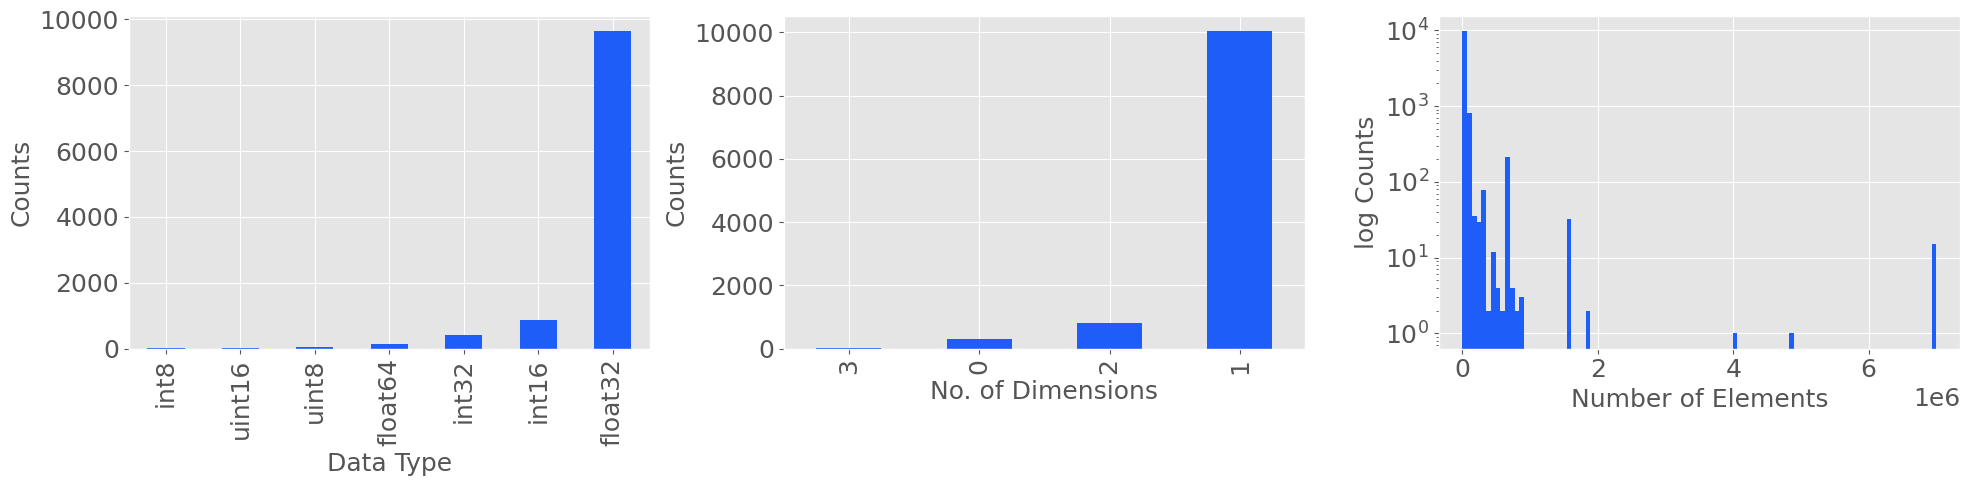

In [31]:
labelsize = 18
mpl.rc('xtick', labelsize=labelsize) 
mpl.rc('ytick', labelsize=labelsize) 
mpl.rc('axes', labelsize=labelsize) 
color = '#1e5df8'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
dtype_counts = data_signals.groupby('dtype').name.count()
dtype_counts = dtype_counts.sort_values()
dtype_counts.plot.bar(ax=ax1, linewidth=1.2, color=color)
ax1.set_ylabel('Counts')
ax1.set_xlabel('Data Type')

n_dims_counts = data_signals.groupby('n_dims').name.count()
n_dims_counts = n_dims_counts.sort_values()
n_dims_counts.plot.bar(ax=ax2, linewidth=1.2, color=color)
ax2.set_ylabel('Counts')
ax2.set_xlabel('No. of Dimensions')
plt.tight_layout()

n_elements_counts = data_signals.n_elements
n_elements_counts.plot.hist(ax=ax3, bins=100, linewidth=1.2, color=color)
plt.yscale('log')
plt.ylabel('log Counts')
plt.xlabel('Number of Elements')

In [11]:
data_signals = meta_df.loc[meta_df.signal_type == 'data']
time_signals = meta_df.loc[meta_df.signal_type == 'time']

merged = pd.merge(data_signals, time_signals, on='signal_name', suffixes=('_data', '_time'))
merged.loc[merged.n_dims_data != merged.n_dims_time]

,name_data,shape_data,n_dims_data,dtype_data,units_data,label_data,description_data,shot_id_data,n_elements_data,signal_name,...,shape_time,n_dims_time,dtype_time,units_time,label_time,description_time,shot_id_time,n_elements_time,source_name_time,signal_type_time
1,abm/CHANNEL_STATUS/data,"(32,)",1,float32,,channel_status,,30449,32.0,abm/CHANNEL_STATUS,...,(),0,float32,S,channel_status,,30449,1.0,abm,time
2,abm/CHANNEL_TYPE/data,"(32,)",1,float32,,channel_type,,30449,32.0,abm/CHANNEL_TYPE,...,(),0,float32,S,channel_type,,30449,1.0,abm,time
3,abm/GAIN/data,"(32,)",1,float32,,GAIN,,30449,32.0,abm/GAIN,...,(),0,float32,S,GAIN,,30449,1.0,abm,time
4,abm/I-BOL/data,"(7500, 32)",2,float32,W/m^2,i-bol,,30449,240000.0,abm/I-BOL,...,"(7500,)",1,float32,s,i-bol,,30449,7500.0,abm,time
5,abm/KM/data,"(32,)",1,float32,Watts,KM,,30449,32.0,abm/KM,...,(),0,float32,S,KM,,30449,1.0,abm,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,xyc/430/4/DATA/data,"(240, 300)",2,float32,,/xyc/430/4/data,,30449,72000.0,xyc/430/4/DATA,...,"(300,)",1,float64,s,/xyc/430/4/data,,30449,300.0,xyc,time
10487,xyc/LASER_AREA_ENERGY/DATA/data,"(240, 300)",2,float32,,/xyc/laser_area_energy/data,,30449,72000.0,xyc/LASER_AREA_ENERGY/DATA,...,"(300,)",1,float64,s,/xyc/laser_area_energy/data,,30449,300.0,xyc,time
10496,xyc/LASER_AREA_ENERGY2/DATA/data,"(240, 300)",2,float32,,/xyc/laser_area_energy2/data,,30449,72000.0,xyc/LASER_AREA_ENERGY2/DATA,...,"(300,)",1,float64,s,/xyc/laser_area_energy2/data,,30449,300.0,xyc,time
10504,xyc/LASER_TRACKER_GS/DATA/data,"(240, 300)",2,float32,,/xyc/laser_tracker_gs/data,,30449,72000.0,xyc/LASER_TRACKER_GS/DATA,...,"(300,)",1,float64,s,/xyc/laser_tracker_gs/data,,30449,300.0,xyc,time


Multiple Shot files

In [12]:
list(data_dir.glob('*.h5'))

[PosixPath('../data/hdf/30449.h5'), PosixPath('../data/hdf/30469.h5')]

In [13]:
meta_df = pd.concat([load_hdf(data_file) for data_file in data_dir.glob('*.h5')])

sep = '/'
meta_df['n_elements'] = meta_df['shape'].apply(np.prod)
meta_df['signal_name'] = meta_df.name.map(lambda x: sep.join(x.split(sep)[:-1]))
meta_df['source_name'] = meta_df.name.map(lambda x: x.split(sep)[0])
meta_df['signal_type'] = meta_df.name.map(lambda x: x.split(sep)[-1])
meta_df

,name,shape,n_dims,dtype,units,label,description,shot_id,n_elements,signal_name,source_name,signal_type
0,abm/CALIB_SHOT/data,(),0,int16,,Calibration Shot,,30449,1.0,abm/CALIB_SHOT,abm,data
1,abm/CALIB_SHOT/errors,(),0,int16,,Calibration Shot,,30449,1.0,abm/CALIB_SHOT,abm,errors
2,abm/CALIB_SHOT/time,(),0,float32,S,Calibration Shot,,30449,1.0,abm/CALIB_SHOT,abm,time
3,abm/CHANNEL_STATUS/data,"(32,)",1,float32,,channel_status,,30449,32.0,abm/CHANNEL_STATUS,abm,data
4,abm/CHANNEL_STATUS/errors,"(32,)",1,float32,,channel_status,,30449,32.0,abm/CHANNEL_STATUS,abm,errors
...,...,...,...,...,...,...,...,...,...,...,...,...
40396,xyr/430/TE/errors,"(240,)",1,float32,,/xyr/430/Te,,30449,240.0,xyr/430/TE,xyr,errors
40397,xyr/430/TE/time,"(240,)",1,float64,s,/xyr/430/Te,,30449,240.0,xyr/430/TE,xyr,time
40398,xyr/TIME1/data,"(240,)",1,float64,s,Time,,30449,240.0,xyr/TIME1,xyr,data
40399,xyr/TIME1/errors,"(240,)",1,float64,,Time,,30449,240.0,xyr/TIME1,xyr,errors


In [14]:
time_signals = meta_df.loc[meta_df.signal_type == 'time']
time_signals.shot_id.unique()

array([30449])